In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    make_scorer,
)
import matplotlib.pyplot as plt

In [2]:
# Load Dataset from CSV
csv_file_path = 'diabetes.csv' 
df = pd.read_csv(csv_file_path)

# Extract features and target
X = df.iloc[:, :-1].values  # All columns except the last one as features
y = df.iloc[:, -1].values  # The last column as the target

In [3]:
# Encode Target Labels
le = LabelEncoder()
y = le.fit_transform(y)  # Use encoded labels for training
class_names = le.classes_  # Original class names

In [4]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [5]:
# Define Cross-Validation Strategy and Scoring Metrics
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrics for evaluation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

In [6]:
# Hyperparameter Tuning for K in KNN
k_values = range(1, 21)  # Testing K from 1 to 20
cv_results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    k_metrics = {}
    for metric_name, scorer in scoring.items():
        scores = cross_val_score(knn, X_train, y_train, cv=kfold, scoring=scorer)
        k_metrics[metric_name] = {
            'mean': np.mean(scores),
            'std': np.std(scores),
            'scores': scores
        }
    cv_results.append({'k': k, **{key: k_metrics[key]['mean'] for key in k_metrics}})

In [8]:
# Analyze Cross-Validation Results
# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(cv_results)

# Find the best K based on F1 score
best_k = results_df.loc[results_df['f1'].idxmax(), 'k']

In [9]:
# Train and Evaluate the Model with Best K
best_knn = KNeighborsClassifier(n_neighbors=int(best_k))
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)

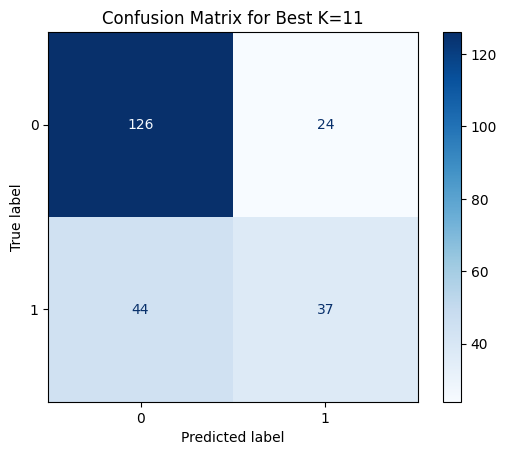

In [10]:
# Display Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix for Best K={best_k}')
plt.show()

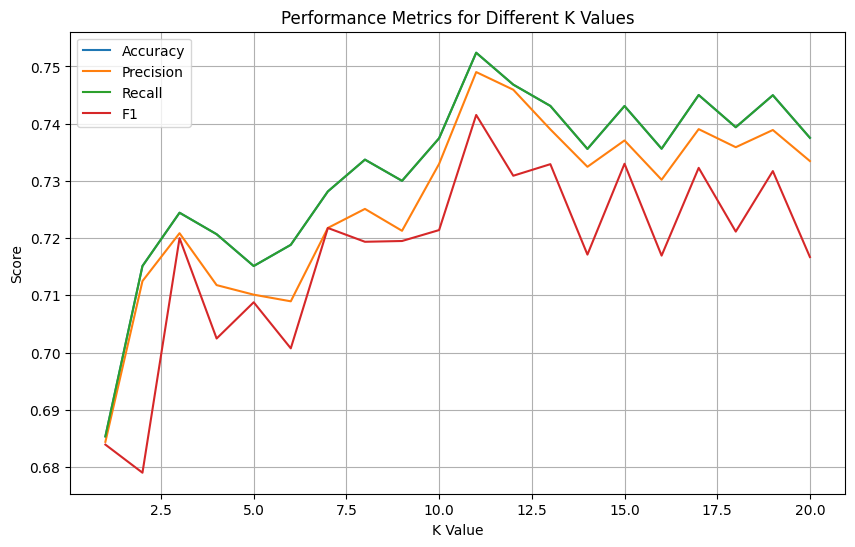

In [11]:
# Plot Performance Metrics Across Different K
plt.figure(figsize=(10, 6))
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    plt.plot(results_df['k'], results_df[metric], label=metric.capitalize())

plt.title('Performance Metrics for Different K Values')
plt.xlabel('K Value')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

In [12]:
# Print Best K and Its Performance Metrics
print(f"Best K: {best_k}")
print(f"Performance Metrics with Best K:")
for metric in scoring.keys():
    print(f"  {metric.capitalize()}: {results_df.loc[results_df['k'] == best_k, metric].values[0]:.4f}")

Best K: 11
Performance Metrics with Best K:
  Accuracy: 0.7524
  Precision: 0.7490
  Recall: 0.7524
  F1: 0.7415


In [13]:
# Save Results for Future Analysis
results_df.to_csv('knn_cross_validation_results.csv', index=False)
print("Cross-validation results saved to 'knn_cross_validation_results.csv'")

Cross-validation results saved to 'knn_cross_validation_results.csv'
